### Libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

import numpy as np
from numpy import trace
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import fashion_mnist
import keras.backend as K
from keras.layers import Input, Dense, Lambda
from keras.layers import Flatten, Reshape
from keras.layers import BatchNormalization, Dropout
from PIL import Image as im
from numpy import cov
from numpy import asarray
from skimage.transform import resize
from itertools import chain
import random
from tensorflow.keras.optimizers import Adam
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import gc

### Dataset

In [ ]:
categories = {0: [],
              1: [],
              2: [],
              3: [],
              4: [],
              5: [],
              6: [],
              7: [],
              8: [],
              9: []}

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

for i in range(32):
    x_train = np.insert(x_train, len(x_train)-1, x_test[i], axis = 0)

x_train = x_train / 255

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
for i in range(32):
    y_train = np.insert(y_train, len(y_train)-1, y_test[i], axis = 0)

In [ ]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

In [ ]:
print(x_train.shape)

(60032, 28, 28, 1)


In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
######################################### If you are facing more errors

In [ ]:
for i in range(len(x_train)):
  categories[y_train[i]].append(x_train[i])

### VAE Components and Methods

In [ ]:
batch_size = 128
hidden_dim = 2 # Since we are in 2D space (images), the dimensions of mean and var are 2
n_epochs = 60

def dropout_and_batchnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

def prior(args):
    mean, log_var, batch_size, hidden_dim = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(log_var / 2) * N + mean

In [ ]:
class VAE:
    def __init__(self, batch_size_, hidden_dim_, epochs_):
        self.batch_size = batch_size_
        self.hidden_dim = hidden_dim_
        self.epochs = epochs_
        self.input_image = Input(batch_shape=(self.batch_size, 28, 28, 1))
        self.encoder, self.latent_space = self.build_the_encoder()
        self.decoder = self.build_the_decoder()

    def build_the_encoder(self):
        x = Flatten()(self.input_image)
        x = Dense(256, activation="relu")(x)
        x = dropout_and_batchnorm(x)
        x = Dense(128, activation="relu")(x)
        x = dropout_and_batchnorm(x)
        # Our prior distribution is N(mean_of_batch, var_of_batch)
        self.mean = Dense(self.hidden_dim)(x)
        self.log_var = Dense(self.hidden_dim)(x)
        # print("K eval: ", K.eval(self.mean))
        # The latent space
        latent_space = Lambda(prior, output_shape=(self.hidden_dim))([self.mean, self.log_var, self.batch_size, self.hidden_dim])
        # The encoder built based on the latent space
        encoder = keras.Model(self.input_image, latent_space)
        return encoder, latent_space

    def build_the_decoder(self):
        input_decoder = Input(shape=(self.hidden_dim,))
        d = Dense(128, activation="relu")(input_decoder)
        d = dropout_and_batchnorm(d)
        d = Dense(256, activation="relu")(d)
        d = dropout_and_batchnorm(d)
        d = Dense(28*28, activation="sigmoid")(d)
        # The final layer
        decoded_image = Reshape((28, 28, 1))(d)
        decoder = keras.Model(input_decoder, decoded_image)
        return decoder

    def loss(self, main, reconstructed):
        main = K.reshape(main, shape=(self.batch_size, 28*28))
        reconstructed = K.reshape(reconstructed, shape=(self.batch_size, 28*28))
        reconstruction_loss = K.sum(K.square(main-reconstructed), axis=-1)
        kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)
        return reconstruction_loss + kl_loss

In [ ]:
vae = VAE(batch_size, hidden_dim, n_epochs)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
latent_sp = vae.encoder(vae.input_image)
model = keras.Model(vae.input_image, vae.decoder(latent_sp))
model.compile(optimizer= "adam", loss=vae.loss)

### Training the VAE

In [ ]:
import time
start_time = time.time()
model.fit(x_train, x_train, epochs=vae.epochs, batch_size = vae.batch_size, shuffle=True)
end_time = time.time()
exe_time = end_time - start_time

Train on 60032 samples
Epoch 1/60
60032/60032 [==============================] - 10s 171us/sample - loss: 59.6968
Epoch 2/60
60032/60032 [==============================] - 4s 63us/sample - loss: 36.2405
Epoch 3/60
60032/60032 [==============================] - 7s 112us/sample - loss: 34.5370
Epoch 4/60
60032/60032 [==============================] - 7s 116us/sample - loss: 33.8131
Epoch 5/60
60032/60032 [==============================] - 7s 121us/sample - loss: 33.3927
Epoch 6/60
60032/60032 [==============================] - 5s 83us/sample - loss: 32.9592
Epoch 7/60
60032/60032 [==============================] - 6s 103us/sample - loss: 32.6829
Epoch 8/60
60032/60032 [==============================] - 4s 72us/sample - loss: 32.5448
Epoch 9/60
60032/60032 [==============================] - 4s 64us/sample - loss: 32.4112
Epoch 10/60
60032/60032 [==============================] - 5s 84us/sample - loss: 32.2666
Epoch 11/60
60032/60032 [==============================] - 4s 64us/sample - loss

In [ ]:
print("Exec Time: ", exe_time)

Exec Time:  270.0280077457428


### Sampling from Latent Space

In [ ]:
label_names = np.array(['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

In [ ]:
latent_points = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
}

In [ ]:
def fill_latent_points(index):
    for i in range(0, len(categories[index]), batch_size):
        if i + batch_size >= len(categories[index]):
            break
        else:
            z_mean, z_log_var = K.function([vae.input_image], [vae.mean, vae.log_var])([np.asarray(categories[index])[i : i + batch_size]])
            if len(latent_points[index]) == 0:
                latent_points[index] = z_mean
            else:
                latent_points[index] = np.append(latent_points[index], z_mean, axis = 0)

In [ ]:
for t in range(10):
    fill_latent_points(t)

In [ ]:
# for i in range(10):
#   plt.figure(figsize=(2, 2))
#   plt.imshow(categories[5][i], cmap = 'gray')
#   plt.axis('off')
#   plt.show()

In [ ]:
def plotting(points, title_, gmm_means, contour = [], label_idcs=None):
    # Creating a scatter plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(x=points[:, 0], y=points[:, 1], s=2.0,
                c=label_idcs, alpha=0.9, zorder=2)

    if len(gmm_means) > 0:
      ax.scatter(gmm_means[:, 0], gmm_means[:, 1], s=16.0,
                  alpha=0.9, zorder=2, color = 'r')

    if len(contour) > 0:
      for i in range(len(contour)):
          ax.add_patch(contour[i])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
    plt.title(title_)
    plt.show()

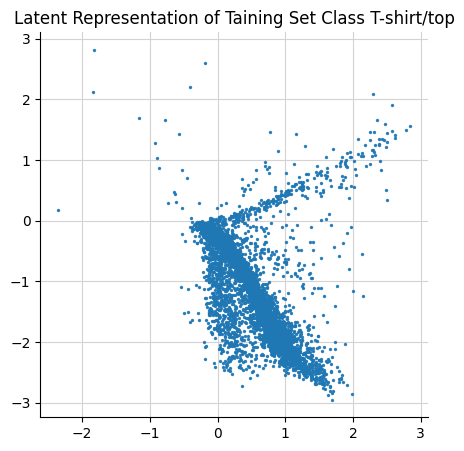

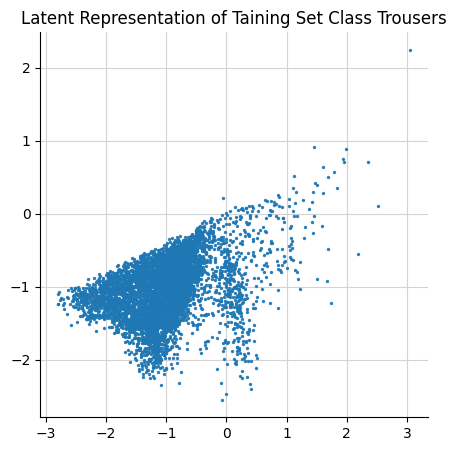

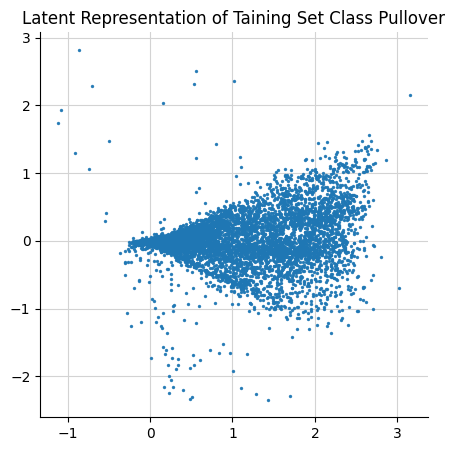

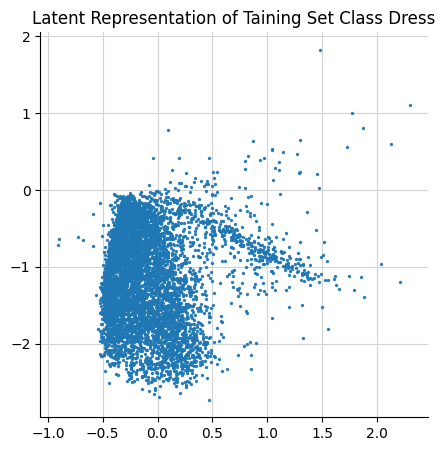

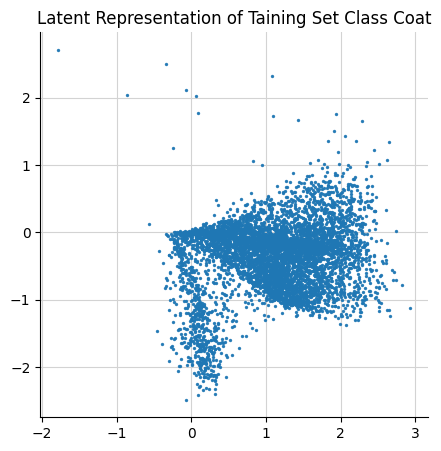

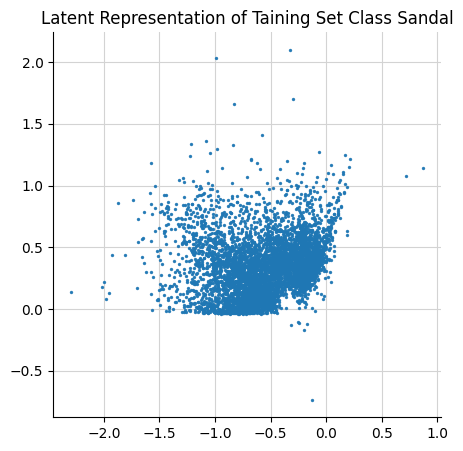

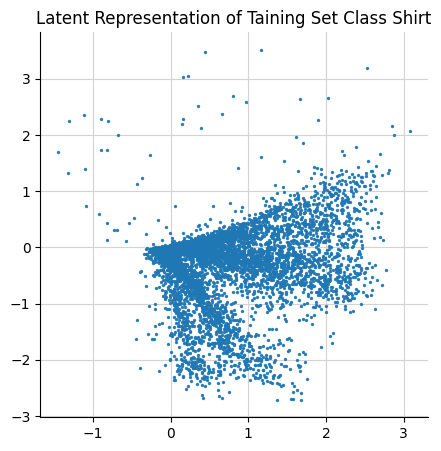

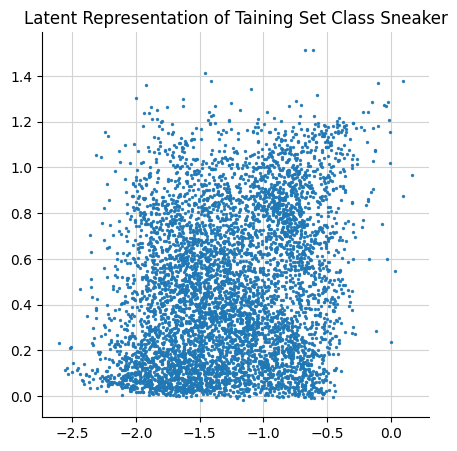

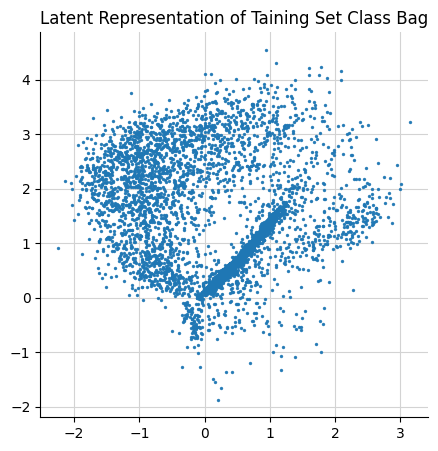

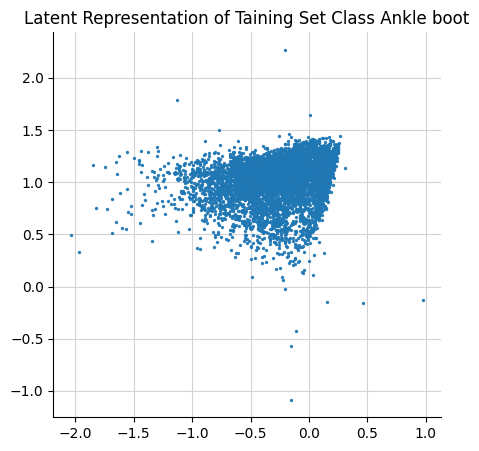

In [ ]:
for i in range(10):

    plotting(latent_points[i],
            title_ = "Latent Representation of Taining Set Class " + label_names[i],
                gmm_means=[], contour = [])

In [ ]:
def get_ellipses(index):
    chi2_val = 5.91
    gmms = gmm_components[index]
    covariances = gmms.covariances_
    means = gmms.means_
    ellipse_covariances = []
    for i in range(len(covariances)):
        eigvals, eigvecs = np.linalg.eigh(covariances[i])
        angle = np.degrees(np.arctan2(*eigvecs[:, 1]))
        width, height = 2 * np.sqrt(eigvals * chi2_val)
        ellipse = Ellipse(means[i], width, height, angle, edgecolor='red', facecolor='none')
        ellipse_covariances.append(ellipse)
    return np.asarray(ellipse_covariances)

In [ ]:
def print_parameters_of_GMM(gmm):
    list_of_means = []
    list_of_covs = []
    for i in range(len(gmm.means_)):
        mean_i = gmm.means_[i]
        cov_i = gmm.covariances_[i]
        print('Mean of', i + 1, 'th component: \t\t' , mean_i)
        print('Covariance matrix of', i + 1, 'th component: \t', cov_i[0],'\n\t\t\t\t\t', cov_i[1])
        print('\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n')

In [ ]:
gmm_components = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
}

In [ ]:
number_of_gaussians = 3

In [ ]:
for current_label in range(10):
    gmm = GaussianMixture(n_components = number_of_gaussians,
                           covariance_type = 'full',
                           init_params = 'kmeans',
                           max_iter = 500,
                           )

    components = gmm.fit(latent_points[current_label])
    gmm_components[current_label] = components

<ipython-input-28-b53ce9389dd6>:11: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(means[i], width, height, angle, edgecolor='red', facecolor='none')


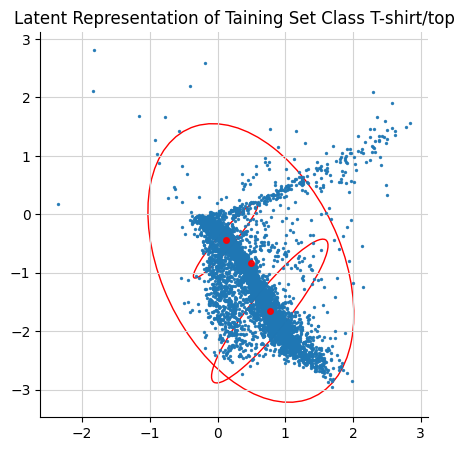

Mean of 1 th component: 		 [ 0.12013464 -0.44085549]
Covariance matrix of 1 th component: 	 [ 0.03861708 -0.04953711] 
					 [-0.04953711  0.07083407]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [ 0.77095702 -1.65196692]
Covariance matrix of 2 th component: 	 [ 0.12528137 -0.16295541] 
					 [-0.16295541  0.25576493]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [ 0.49144041 -0.82995901]
Covariance matrix of 3 th component: 	 [0.39143929 0.22625875] 
					 [0.22625875 0.95998325]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



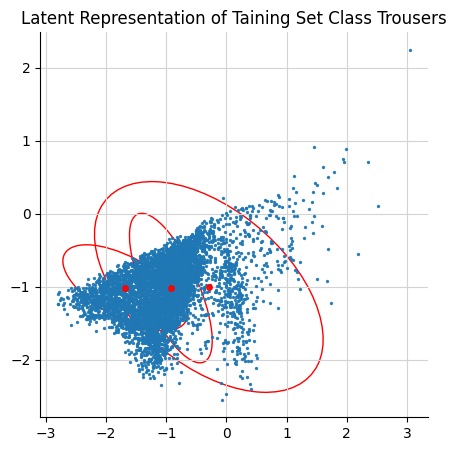

Mean of 1 th component: 		 [-0.92509952 -1.01604784]
Covariance matrix of 1 th component: 	 [0.0801097  0.08383329] 
					 [0.08383329 0.17746064]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-0.29354473 -1.00117095]
Covariance matrix of 2 th component: 	 [0.61162906 0.23127776] 
					 [0.23127776 0.35234809]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [-1.6852018 -1.0111911]
Covariance matrix of 3 th component: 	 [0.18132509 0.06392584] 
					 [0.06392584 0.05844437]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



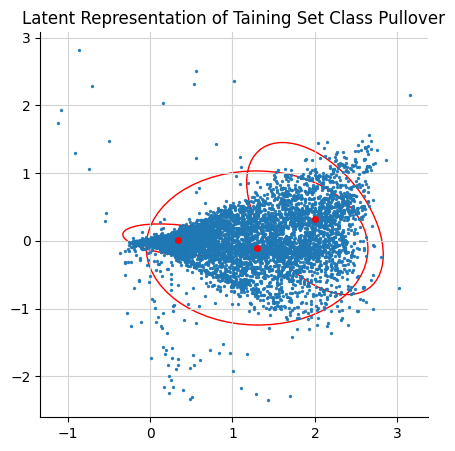

Mean of 1 th component: 		 [ 1.29863663 -0.10551758]
Covariance matrix of 1 th component: 	 [0.30595064 0.00226388] 
					 [0.00226388 0.21866591]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [0.33628034 0.01537823]
Covariance matrix of 2 th component: 	 [0.07513102 0.00871212] 
					 [0.00871212 0.00924983]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [2.00098859 0.32863436]
Covariance matrix of 3 th component: 	 [0.11615353 0.07473837] 
					 [0.07473837 0.21309804]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



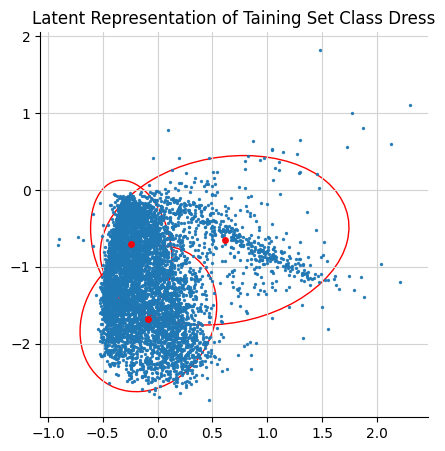

Mean of 1 th component: 		 [-0.08346185 -1.6740982 ]
Covariance matrix of 1 th component: 	 [ 0.0657639  -0.01748845] 
					 [-0.01748845  0.15204926]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-0.24006715 -0.70262031]
Covariance matrix of 2 th component: 	 [0.02323878 0.0125189 ] 
					 [0.0125189  0.11645977]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [ 0.61171233 -0.65332765]
Covariance matrix of 3 th component: 	 [ 0.21776065 -0.03252265] 
					 [-0.03252265  0.20519269]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



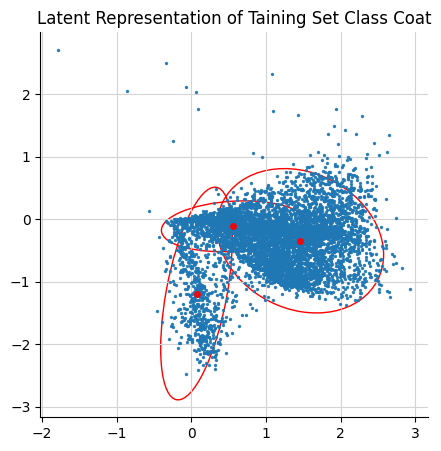

Mean of 1 th component: 		 [ 0.0698717  -1.18974501]
Covariance matrix of 1 th component: 	 [ 0.03903045 -0.07099698] 
					 [-0.07099698  0.48976615]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [ 1.46048445 -0.34566574]
Covariance matrix of 2 th component: 	 [0.21080346 0.04203166] 
					 [0.04203166 0.22569211]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [ 0.560751   -0.11365261]
Covariance matrix of 3 th component: 	 [ 0.15628752 -0.01053428] 
					 [-0.01053428  0.02801604]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



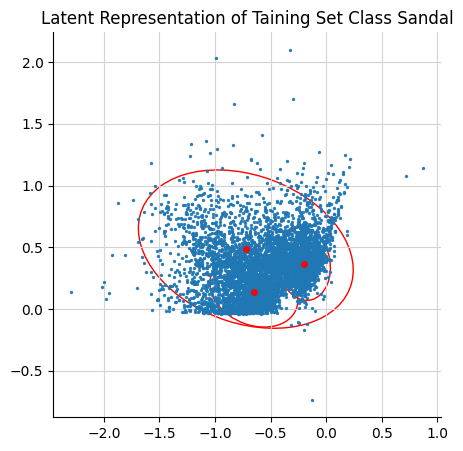

Mean of 1 th component: 		 [-0.72293966  0.48543521]
Covariance matrix of 1 th component: 	 [0.15823148 0.02752044] 
					 [0.02752044 0.06945951]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-0.19831876  0.36549927]
Covariance matrix of 2 th component: 	 [0.00949042 0.00123069] 
					 [0.00123069 0.01469726]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [-0.65034918  0.13943391]
Covariance matrix of 3 th component: 	 [0.0265126  0.00450018] 
					 [0.00450018 0.01376245]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



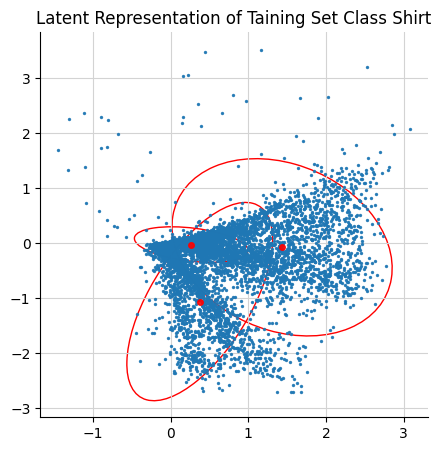

Mean of 1 th component: 		 [ 0.26453327 -0.02445752]
Covariance matrix of 1 th component: 	 [0.09086212 0.01381252] 
					 [0.01381252 0.01768239]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [ 0.37368638 -1.06011892]
Covariance matrix of 2 th component: 	 [ 0.1492096  -0.18014523] 
					 [-0.18014523  0.54914875]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [ 1.43452806 -0.07395966]
Covariance matrix of 3 th component: 	 [0.34026249 0.09091701] 
					 [0.09091701 0.43886354]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



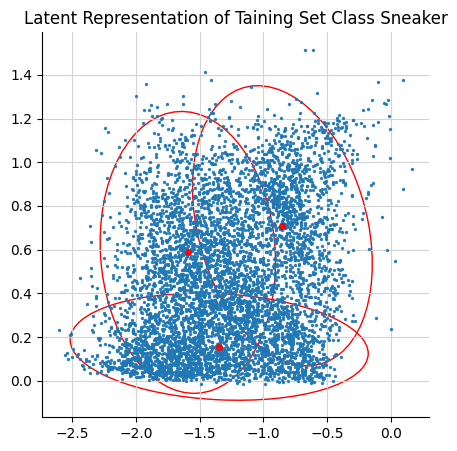

Mean of 1 th component: 		 [-0.8505431   0.70903743]
Covariance matrix of 1 th component: 	 [0.08427454 0.02097392] 
					 [0.02097392 0.06954712]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-1.34663116  0.15517827]
Covariance matrix of 2 th component: 	 [0.23159225 0.00622324] 
					 [0.00622324 0.01015814]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [-1.59306756  0.58698421]
Covariance matrix of 3 th component: 	 [0.08016045 0.00537183] 
					 [0.00537183 0.07043463]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



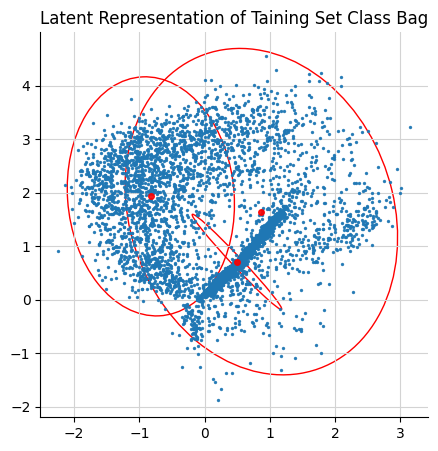

Mean of 1 th component: 		 [0.49464324 0.70890394]
Covariance matrix of 1 th component: 	 [0.0796998  0.10210639] 
					 [0.10210639 0.13380585]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-0.82514419  1.93324994]
Covariance matrix of 2 th component: 	 [0.27797081 0.03252193] 
					 [0.03252193 0.84467607]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [0.8690139 1.647638 ]
Covariance matrix of 3 th component: 	 [0.73811759 0.17014535] 
					 [0.17014535 1.57449654]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



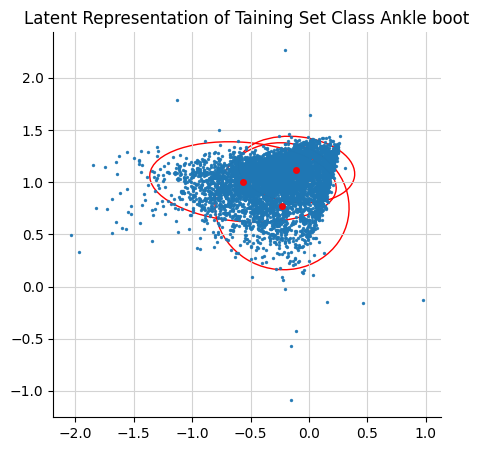

Mean of 1 th component: 		 [-0.10619444  1.12016938]
Covariance matrix of 1 th component: 	 [0.04209219 0.00348117] 
					 [0.00348117 0.01733949]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-0.56458132  1.0022348 ]
Covariance matrix of 2 th component: 	 [0.10794756 0.00778809] 
					 [0.00778809 0.02511652]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [-0.2301203   0.76932545]
Covariance matrix of 3 th component: 	 [0.0558484  0.00148817] 
					 [0.00148817 0.06268609]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



In [ ]:
for i in range(10):
    ellipses = get_ellipses(i)

    plotting(latent_points[i],
            title_ = "Latent Representation of Taining Set Class " + label_names[i],
                gmm_means=gmm_components[i].means_, contour = ellipses)

    print_parameters_of_GMM(gmm_components[i])

### Sampling from Latent Space for Decoder

In [ ]:
sampled_latent_points = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
}

In [ ]:
def sample_from_gmm(index):
    gmms = gmm_components[index]
    means = gmms.means_
    weights = gmms.weights_
    # print('Weights: ')
    # print(weights)
    covariances = gmms.covariances_
    num_samples = 1000
    sampled = []
    for i in range(len(weights)):
        standard_samples = np.random.multivariate_normal(means[i], covariances[i], int(num_samples * round(weights[i], 3)))
        if i == 0: sampled = standard_samples
        else:  sampled = np.append(sampled, standard_samples, axis = 0)
        # print(sampled.shape)
    # print(len(sampled))
    return np.asarray(sampled)

In [ ]:
for t in range(10):
    sampled_points = sample_from_gmm(t)
    # print(len(sampled_points))
    # print("For the ", t, "th label")
    # print(sampled_points.shape)
    # print(sampled_points[0])
    # print("\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n")
    sampled_latent_points[t] = sampled_points

<ipython-input-28-b53ce9389dd6>:11: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(means[i], width, height, angle, edgecolor='red', facecolor='none')


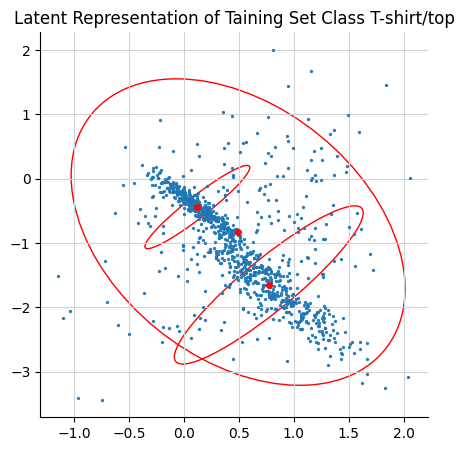

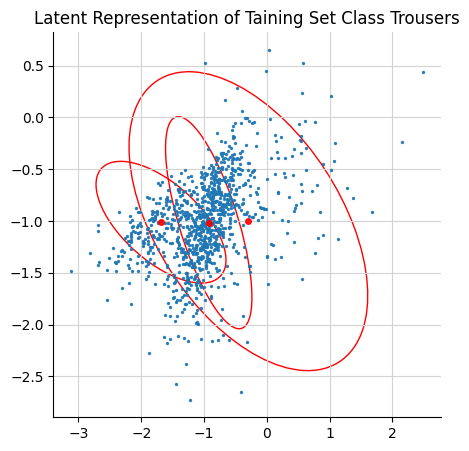

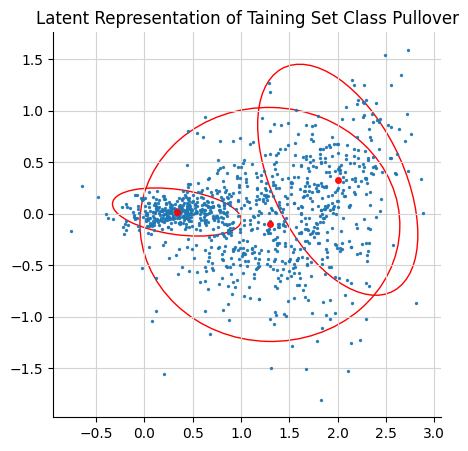

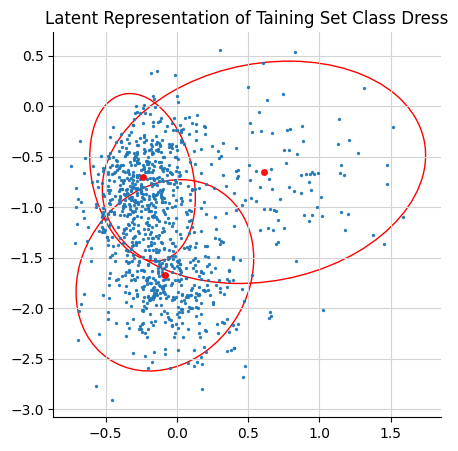

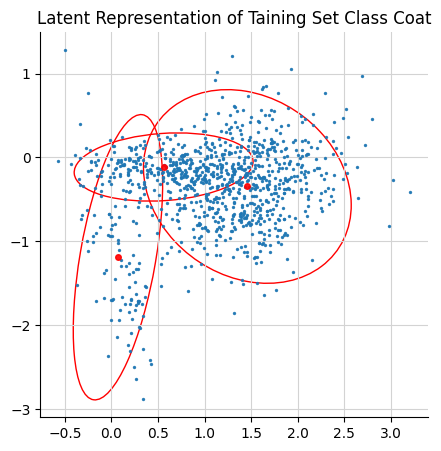

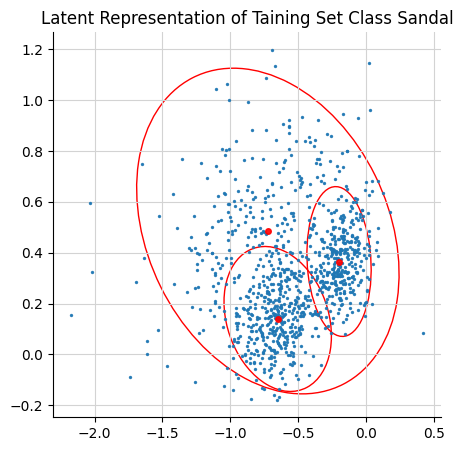

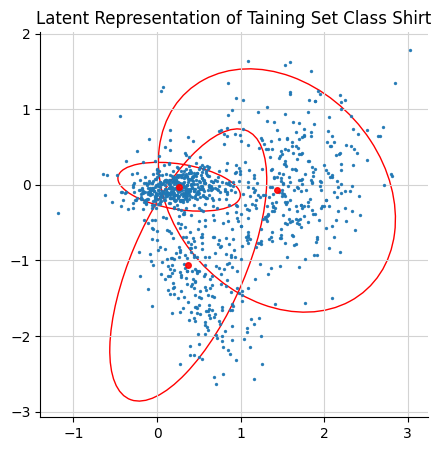

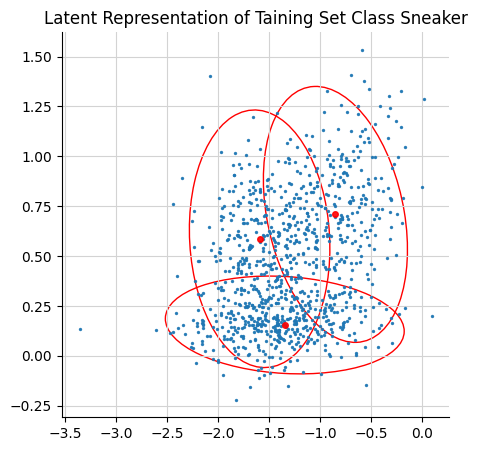

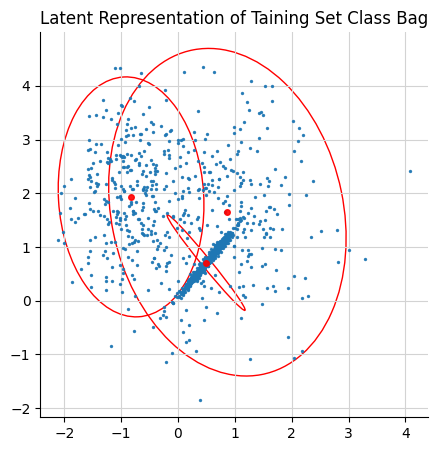

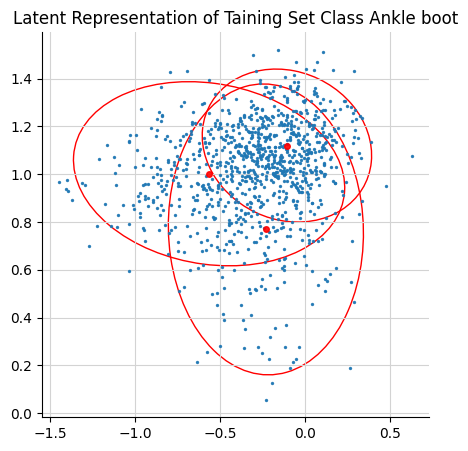

In [ ]:
for i in range(10):
  ellipses = get_ellipses(i)
  plotting(sampled_latent_points[i],
         title_ = "Latent Representation of Taining Set Class " + label_names[i], gmm_means=gmm_components[i].means_, contour = ellipses)

### FID Score with Inception-V3

In [ ]:
images = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
}

In [ ]:
fid_score_list = []

In [ ]:
for i in range(10):
    for j in range(len(sampled_latent_points[i])):
          image = vae.decoder.predict(np.expand_dims(sampled_latent_points[i][j], axis=0))
          fid_score_list.append(image[0])
          images[i].append(image[0])

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
def plot_same_images(index, tit):
    fig = plt.figure(figsize=(4, 4))
    rows = 4
    cols = 4
    plt.suptitle(tit)
    for i in range(rows * cols):
      fig.add_subplot(rows, cols, i+1)
      rand = random.randrange(len(images[index]))
      plt.imshow(images[index][rand], cmap = 'gray')
      plt.axis('off')
    plt.show()

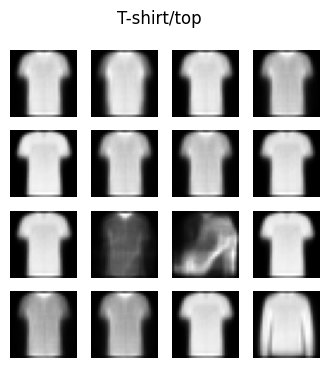

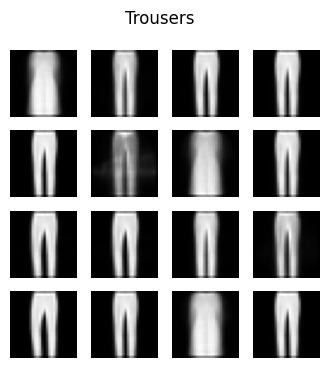

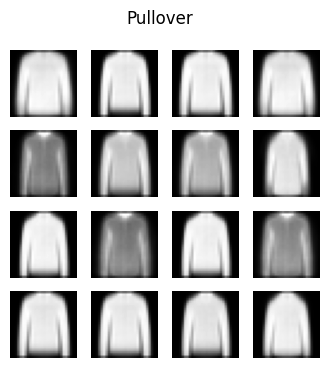

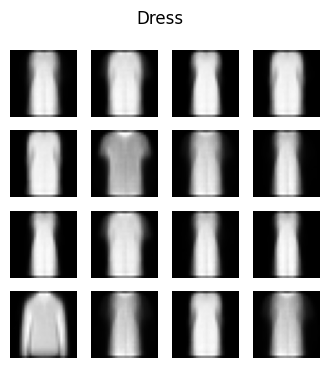

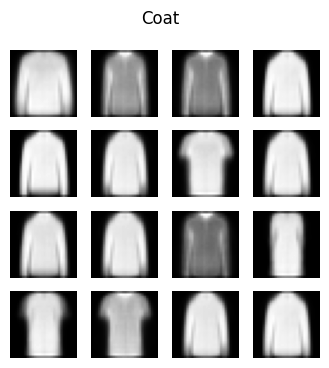

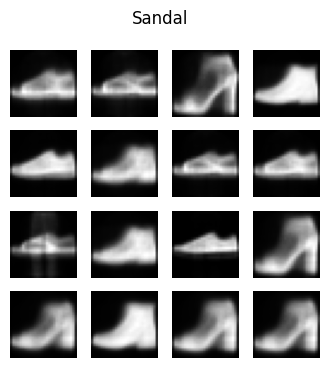

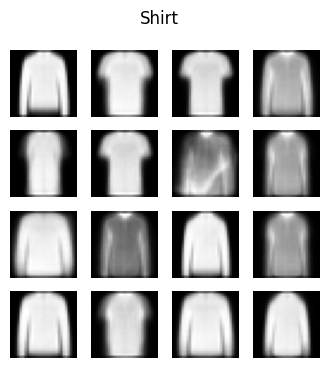

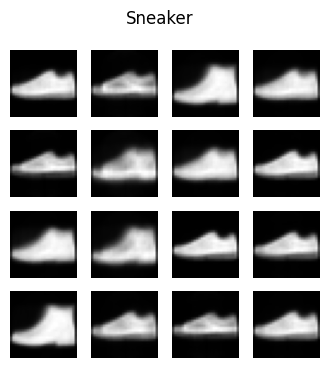

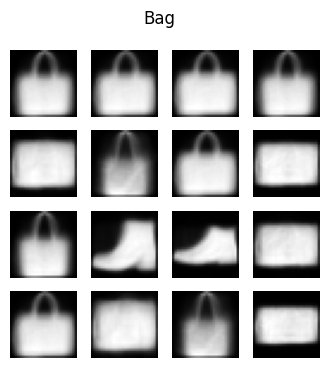

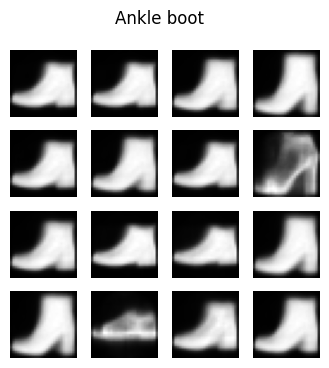

In [ ]:
for i in range(10):
  plot_same_images(i, label_names[i])
  print('\n\n\n')

In [ ]:
fid_score_list = np.asarray(fid_score_list)
print(fid_score_list.shape)
print(x_train.shape)

(10002, 28, 28, 1)
(60032, 28, 28, 1)


In [ ]:
from fid00 import FID_measure
import random

gc.collect()

39812

In [ ]:
fid = FID_measure(gen_images_ = fid_score_list, train_set_ = x_train, labels_ = y_train)
train_set_shrinked, train_set_shrinked_labels = fid.sample_uniformly()

Train set len :  60032
Middle of sample uniformly
Train set len :  10000
End of sample uniformly


In [ ]:
score = fid.calculate_fid()
print('FID: %.3f' % score)

train_images before preprocess:  (10000, 28, 28, 1)
gen images before preprocess:  (10001, 28, 28, 1)
train_images after scale:  (10000, 299, 299, 3)
gen images after scale:  (10001, 299, 299, 3)
train_images after preprocess:  (10000, 299, 299, 3)
gen images after preprocess:  (10001, 299, 299, 3)
87910968/87910968 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Inception-V3 output for gen images:  (10001, 2048)
Inception-V3 output for train images:  (10000, 2048)
Mu1 shape:  (2048,)
Sigma1 shape:  (2048, 2048)
Mu2 shape:  (2048,)
Sigma2 shape:  (2048, 2048)
FID: 10.360


### Mean and Covariance Matrices of Training and Generated Images

In [ ]:
def calc_mu_and_sigma(dataset):
    # The returned sigma is the covariance matrix and mu is the mean
    flatten_images = []

    for i in range(len(dataset)):
        vectorize = np.array(list(chain.from_iterable(dataset[i])))
        flatten_images.append(vectorize)

    flatten_images = np.array(flatten_images)
    print("Flatten images: ", flatten_images.shape)
    mu = flatten_images.mean(axis = 0)
    print("Mu: ", mu.shape)
    sigma = np.dot(flatten_images[0], flatten_images[0].T)

    print("Sigma: ", sigma.shape)

    for i in range(1, len(flatten_images)):
        Ui = np.dot(flatten_images[i], flatten_images[i].T)
        sigma += Ui

    mu_mu_T = np.dot(mu, mu.T)
    sigma = sigma / len(dataset)
    sigma = sigma - mu_mu_T

    return mu, sigma, flatten_images

In [ ]:
mu_train, sigma_train, vectorized_train = calc_mu_and_sigma(train_set_shrinked)

Flatten images:  (10000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
mu_gen, sigma_gen, vectorized_gen = calc_mu_and_sigma(fid_score_list)

Flatten images:  (10002, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


### CNN for Predicting Generated Images

In [ ]:
from keras.models import load_model
cnn = load_model('CNN_fashion.h5')

In [ ]:
preds_gen = cnn.predict(fid_score_list)
pred_labels_gen = np.argmax(preds_gen, axis=1)

In [ ]:
unique_elements, counts = np.unique(label_names[pred_labels_gen], return_counts=True)
frequency = dict(zip(unique_elements, counts))
print("Frequency of Elements: ")
print(frequency)

Frequency of Elements: 
{'Ankle boot': 1548, 'Bag': 706, 'Coat': 725, 'Dress': 1026, 'Pullover': 1722, 'Sandal': 1, 'Shirt': 357, 'Sneaker': 1573, 'T-shirt/top': 1425, 'Trousers': 919}


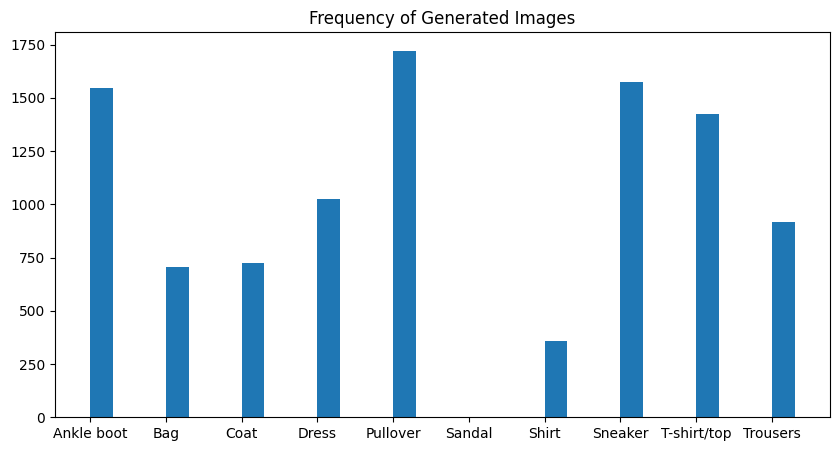

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(unique_elements, counts, align = 'edge', width = 0.3)
plt.xticks(np.arange(10))
plt.title('Frequency of Generated Images')
plt.show()

### Viewing Dimension-Reduced Generated Images

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def scatter(first_axis, second_axis, labels, title):
    plt.figure(figsize=(10, 8))
    unique_classes = set(labels)
    plt.title(title)
    colors = ["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "cyan", "magenta"]
    for i, class_label in enumerate(unique_classes):
        class_indices = [j for j, c in enumerate(labels) if c == class_label]
        plt.scatter([first_axis[idx] for idx in class_indices],
                    [second_axis[idx] for idx in class_indices],
                    color=colors[i % len(colors)],
                    label=f'Class {class_label}')

    plt.legend()
    plt.show()


def map_diversity(data, variance_PCA):
    if data.ndim == 3:
        data = data.squeeze()
    pca = PCA(n_components = variance_PCA)
    reduced_vectors_pca = pca.fit_transform(data)
    print("Number of Components: ", pca.n_components_) # If interested
    tsne = TSNE(n_components=2)
    plt.title("Number of Components to reach variance of " + str(variance_PCA) + " in the PCA: " + str(pca.n_components_))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.show()
    reduced_vectors_tsne = tsne.fit_transform(reduced_vectors_pca)
    return reduced_vectors_tsne

Number of Components:  5


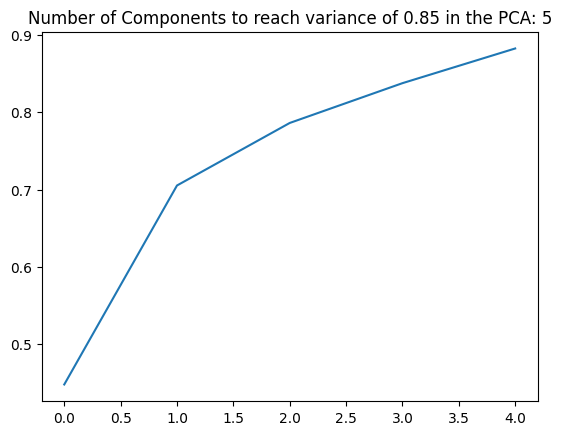

In [ ]:
reduced_dimension_gen = map_diversity(data = vectorized_gen, variance_PCA = 0.85)

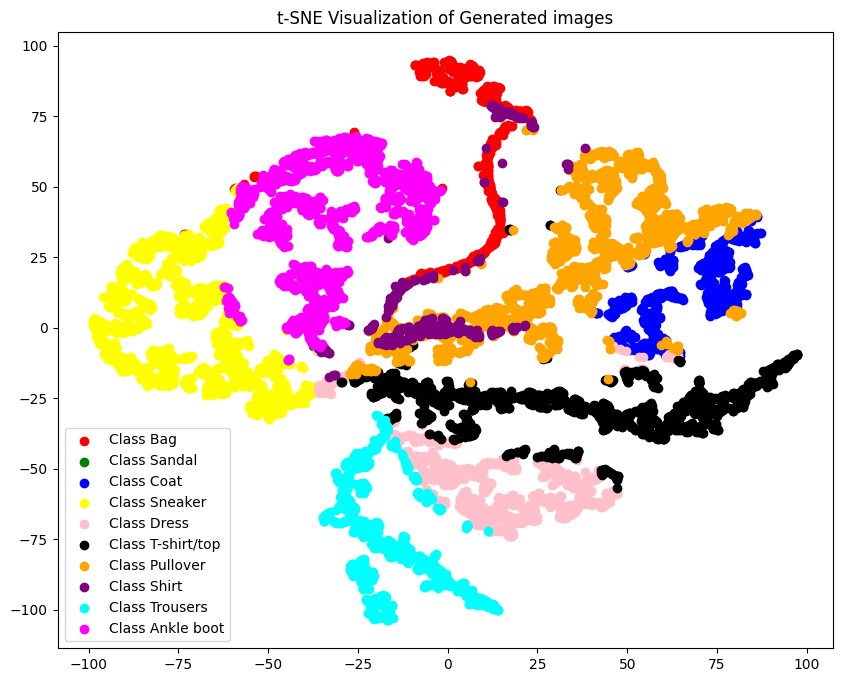

In [ ]:
scatter(reduced_dimension_gen[:, 0], reduced_dimension_gen[:, 1], label_names[pred_labels_gen], 't-SNE Visualization of Generated images')

In [ ]:
_, _, vectorized_train_not_shrinked = calc_mu_and_sigma(x_train)

Flatten images:  (60032, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


Number of Components:  43


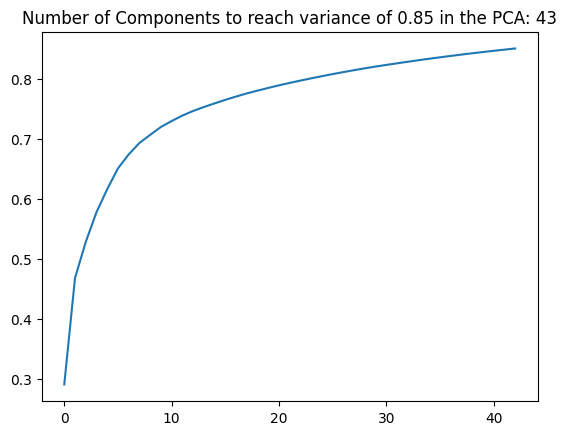

KeyboardInterrupt: 

In [ ]:
reduced_dimension_train = map_diversity(data = vectorized_train_not_shrinked, variance_PCA = 0.85)

In [ ]:
preds_train = cnn.predict(x_train)
pred_labels_train = np.argmax(preds_train, axis=1)

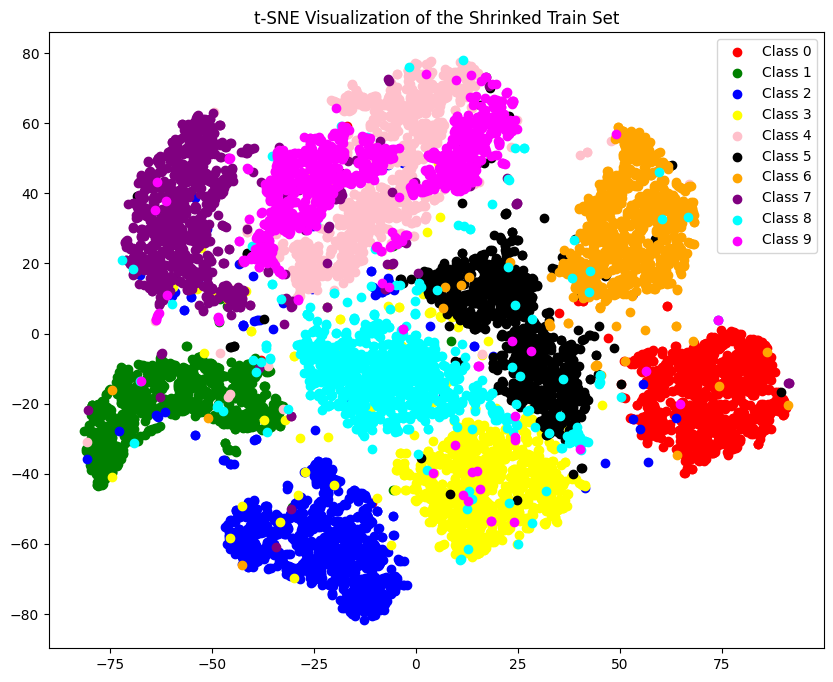

In [ ]:
scatter(reduced_dimension_train[:, 0], reduced_dimension_train[:, 1], label_names[pred_labels_train], 't-SNE Visualization of the Shrinked Train Set')

### Precision, Recall, Diversity, Coverage Metrics

In [ ]:
print(reduced_dimension_train.shape)
print(reduced_dimension_gen[:10000].shape)

(10000, 2)
(10000, 2)


In [ ]:
gc.collect()

3461

In [ ]:
!pip3 install prdc

from prdc import compute_prdc

In [ ]:
for j in np.asarray([5, 10, 6, 3, 2, 1]):
    print(j, "-Nearest Neighbors")
    metrics = compute_prdc(real_features = reduced_dimension_train,
                          fake_features = reduced_dimension_gen[:10000],
                          nearest_k=j)

    print(metrics)
    print("\n----------------------------------\n")

5 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.582, 'recall': 0.4296, 'density': 0.47534000000000004, 'coverage': 0.3926}

----------------------------------

10 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.6302, 'recall': 0.5674, 'density': 0.49582, 'coverage': 0.5062}

----------------------------------

6 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.5961, 'recall': 0.4619, 'density': 0.47668333333333335, 'coverage': 0.421}

----------------------------------

3 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.5164, 'recall': 0.3489, 'density': 0.4437, 'coverage': 0.3022}

----------------------------------

2 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.4428, 'recall': 0.2907, 'density': 0.4115, 'coverage': 0.2273}

----------------------------------

1 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.2844, 'recall': 0.1911, 'density': 0.3592, 'coverage': 0.133